# Imports

In [28]:
# import some common libraries
import numpy as np
import os, cv2
import torch, torchvision
from zipfile import ZipFile
from PIL import Image
import os, sys
import matplotlib.pyplot as plt
import urllib.request as rq
from copy import deepcopy
import json
import tqdm as tqdm
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg



# Model setup


In [29]:
# Set config 

cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2  # set threshold for this model
# Find a model from detectron2's model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
# Create Predictor

predictor = DefaultPredictor(cfg)

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


# Loading our data


In [30]:
# Reading the zip file 

resp = "val2017.zip"

archive = ZipFile((resp))

count = 0  # Setting a number to limit the number of images we are going to read

# Creating a directory that contains images with sky removed

if not os.path.isdir( 'sky_treminated_images' ) :
    os.mkdir( 'sky_treminated_images' )  # make sure the directory exists

coco_url = 'http://images.cocodataset.org/'
# Loading the annotations
with open('instances_val2017.json') as f:
        annotations = json.load(f)


# Helper functions

*get_items_in_pic*

a function to extract annotations of an image in the coco data set

In [31]:
def get_items_in_pic(picture_name, annotations):
    """
    get a picture name and annotations list
    return list of dicts contains objects in that picture
    according to the coco dataset 
    """
    output_dict = []
    # Get the image id, according to the annotations
    for i in range(len(annotations['images'])):
        if annotations['images'][i]['file_name'] == picture_name:
            image_id = annotations['images'][i]['id']
            break # We found the id lets stop this loop
    # Get the image's annotation dicts     
    for i in range(len(annotations['annotations'])):
            if annotations['annotations'][i]['image_id'] == image_id:
                output_dict.append(annotations['annotations'][i])
            
    return output_dict

*update_bbox_after_removing_segment*

1. Delete every object outside the frame

2. Edit the bounding box accornding to the new border

In [32]:
def update_bbox_after_removing_segment(ystart_cut,yend_cut,object_list):
    """
    start_cut: y pos the starting line that we cut the background from
    end_cut: y pos of the ending line we cut the background from
    object_list: a dict contains an info of elements according to the coco dataset 
    
    returns an object_list without the elements that got cut 
    """
    
    object_list_output = deepcopy(object_list)
    segment_size = yend_cut - ystart_cut
    # First let's remove objects that are not in the new image
    for i,obj in enumerate(object_list):
        y = object_list[i]['bbox'][1]
        y_h = y + object_list[i]['bbox'][3]
        if yend_cut>y_h and ystart_cut<y:
            object_list_output.remove(obj)
            
    object_list_output_2 = object_list_output

    # Now for what's left, let's update the new bboxes according to the new borders            
    for i,obj in enumerate(object_list_output_2):
        y = object_list_output_2[i]['bbox'][1]
        y_h = y + object_list_output_2[i]['bbox'][3]
        
        if yend_cut>y and ystart_cut<y:
            object_list_output_2[i]['bbox'][3] = y_h - yend_cut - 1
            object_list_output_2[i]['bbox'][1] = yend_cut - 1
        elif yend_cut<y and ystart_cut>y:
            object_list_output_2[i]['bbox'][3] = ystart_cut + 1
        
        object_list_output_2[i]['bbox'][1] = object_list_output_2[i]['bbox'][1] - segment_size
    return object_list_output_2

*get_image_from_id*

image_id to image name

In [33]:
def get_image_from_id(image_id,annotations):
    """
    gets an image id
    returns image url
    """
    for i in range(len(annotations['images'])):
        if annotations['images'][i]['id'] == image_id:
            return annotations['images'][i]

In [34]:
def bbox_list(object_list):
    """
    get a list with info on object's annotations
    returns a list with bboxes of object's annotations
    """
    bbox_list = []
    for i in object_list:
        bbox_list.append(i['bbox'])
    return bbox_list

In [35]:
# load image from url
def urlToImage(url):
    """
    from here:
    https://stackoverflow.com/questions/55018755/how-to-cv2-imread-from-a-url-with-basic-authentication
    """
    # download image,convert to a NumPy array,and read it into opencv
    resp = rq.urlopen(url)
    img = np.asarray(bytearray(resp.read()),dtype="uint8")
    img = cv2.imdecode(img,cv2.IMREAD_COLOR)

    #return the image
    return img

In [36]:
def draw_bbox(image_url,bbox_list, x_y_slice = None):
    """
    gets an image_url and bbox list
    draw a box on it, display it
    """
    img = urlToImage(image_url)
    
    if x_y_slice!= None:
        img = np.delete(img, slice(x_y_slice[0], x_y_slice[1]), axis=0)
        
    for bbox in bbox_list:
        if len(bbox)>0:
            x = int(bbox[0])
            y = int(bbox[1])
            x_w = int(bbox[2]) + x
            y_h = int(bbox[3]) + y
            # Display the image
        
            img = cv2.rectangle(img, (x, y), (x_w, y_h), (0, 0, 255), 2)
        

    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb, cmap = plt.cm.Spectral)    

In [37]:
def delete_annotations(annotations,picture_name):
    """
    get annotations and picture name
    detelte all the bboxes of given image in the annotations json
    """

    # Get the image id, according to the annotations
    for i in range(len(annotations['images'])):
        if annotations['images'][i]['file_name'] == picture_name:
            image_id = annotations['images'][i]['id']
            break # We found the id lets stop this loop

    # Get the image's annotation      
    for i in range(len(annotations['annotations'])):
            if annotations['annotations'][i]['image_id'] == image_id:
                #delete annotations of that image
                annotations['annotations'][i]['bbox'] = []
            
    return annotations

In [38]:
def save_annotations(picture_name,obj_edit,annotations):
    """
    get an edited object, obj_edit
    get annotations
    save obj_edit elements into annotations
    """
    if len(obj_edit) != 0:
        for j in range(len(obj_edit)):
            id = obj_edit[j]['id']
        for i in range(len(annotations['annotations'])):
            if annotations['annotations'][i]['id'] == id:
                annotations['annotations'][i] = obj_edit[j]
    else:
        annotations = delete_annotations(annotations,picture_name)
    return annotations

# Starting iteration on each image, each time an image with a sky is selected, we will DESTROY the sky in it

val2017/000000119038.jpg
old bbox: [[485.34, 233.06, 115.02, 101.38], [508.64, 198.84, 117.01, 125.35], [359.28, 205.25, 70.0, 66.2]]


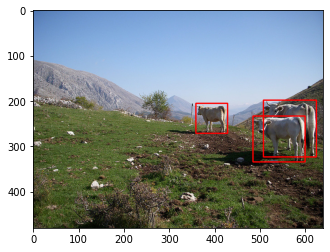

new bbox: [[485.34, 14.060000000000002, 115.02, 101.38], [508.64, -1, 117.01, 104.19], [359.28, -1, 70.0, 51.44999999999999]]


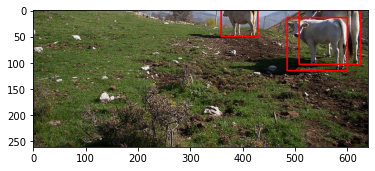

val2017/000000365745.jpg
old bbox: [[140.22, 135.98, 404.5, 249.17], [1.08, 205.95, 152.43, 92.97], [368.83, 117.69, 12.87, 26.36], [541.07, 171.26, 10.06, 17.88], [576.0, 237.3, 64.0, 155.33], [598.2, 257.92, 41.47, 37.08], [553.74, 221.26, 21.93, 58.1], [434.18, 179.02, 6.52, 12.82]]


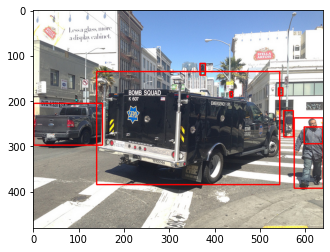

new bbox: [[140.22, -1, 404.5, 239.14999999999998], [1.08, 60.94999999999999, 152.43, 92.97], [541.07, 26.25999999999999, 10.06, 17.88], [576.0, 92.30000000000001, 64.0, 155.33], [598.2, 112.92000000000002, 41.47, 37.08], [553.74, 76.25999999999999, 21.93, 58.1], [434.18, 34.02000000000001, 6.52, 12.82]]


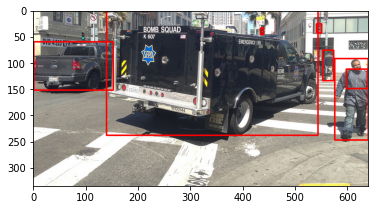

val2017/000000320425.jpg
old bbox: [[81.58, 155.24, 91.14, 151.78], [176.01, 162.23, 54.0, 205.22], [177.93, 154.13, 133.22, 222.53], [259.24, 159.06, 211.41, 226.41], [298.56, 107.19, 161.3, 363.19], [383.47, 175.07, 201.01, 210.67], [386.86, 178.8, 55.35, 66.19], [338.98, 366.36, 94.52, 113.64], [23.71, 169.41, 136.47, 153.93], [558.07, 421.43, 81.93, 58.57]]


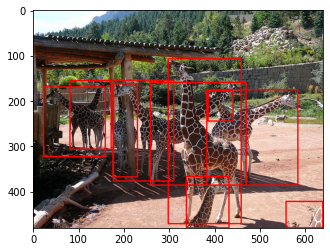

new bbox: [[81.58, 99.24000000000001, 91.14, 151.78], [176.01, 106.22999999999999, 54.0, 205.22], [177.93, 98.13, 133.22, 222.53], [259.24, 103.06, 211.41, 226.41], [298.56, 51.19, 161.3, 363.19], [383.47, 119.07, 201.01, 210.67], [386.86, 122.80000000000001, 55.35, 66.19], [338.98, 310.36, 94.52, 113.64], [23.71, 113.41, 136.47, 153.93], [558.07, 365.43, 81.93, 58.57]]


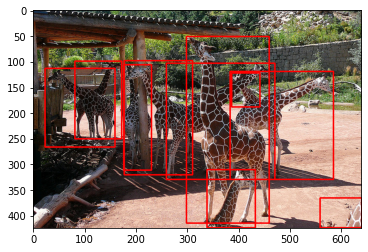

val2017/000000335328.jpg
old bbox: [[336.95, 221.08, 155.29, 109.86], [51.61, 330.52, 164.58, 97.69], [122.8, 380.66, 59.19, 53.74]]


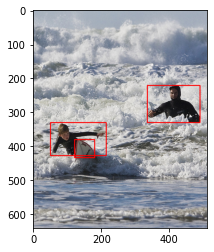

new bbox: [[336.95, 69.08000000000001, 155.29, 109.86], [51.61, 178.51999999999998, 164.58, 97.69], [122.8, 228.66000000000003, 59.19, 53.74]]


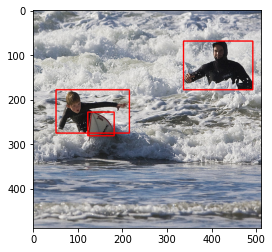

val2017/000000158548.jpg
old bbox: [[139.86, 236.43, 44.8, 69.51], [429.52, 186.28, 37.89, 17.78], [529.78, 180.73, 45.08, 78.77], [208.46, 182.62, 14.05, 41.14], [225.43, 190.91, 11.35, 15.82], [618.77, 185.53, 8.13, 21.0], [258.37, 191.58, 4.16, 10.67], [490.59, 186.44, 5.4, 15.79], [251.72, 191.56, 3.49, 8.62], [327.85, 161.21, 147.64, 36.91], [499.2, 184.31, 6.77, 14.89], [584.55, 182.97, 6.52, 9.38], [589.67, 185.68, 5.34, 10.67], [602.21, 189.1, 7.46, 14.92], [280.66, 191.23, 9.39, 8.11], [543.07, 193.34, 4.58, 3.66], [382.85, 171.56, 26.42, 25.72], [298.44, 164.65, 21.57, 20.05], [513.75, 189.02, 5.18, 13.42], [489, 174, 150, 37]]


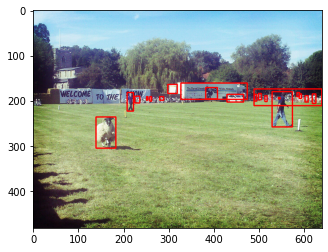

new bbox: [[139.86, 115.43, 44.8, 69.51], [429.52, 65.28, 37.89, 17.78], [529.78, 59.72999999999999, 45.08, 78.77], [208.46, 61.620000000000005, 14.05, 41.14], [225.43, 69.91, 11.35, 15.82], [618.77, 64.53, 8.13, 21.0], [258.37, 70.58000000000001, 4.16, 10.67], [490.59, 65.44, 5.4, 15.79], [251.72, 70.56, 3.49, 8.62], [327.85, 40.21000000000001, 147.64, 36.91], [499.2, 63.31, 6.77, 14.89], [584.55, 61.97, 6.52, 9.38], [589.67, 64.68, 5.34, 10.67], [602.21, 68.1, 7.46, 14.92], [280.66, 70.22999999999999, 9.39, 8.11], [543.07, 72.34, 4.58, 3.66], [382.85, 50.56, 26.42, 25.72], [298.44, 43.650000000000006, 21.57, 20.05], [513.75, 68.02000000000001, 5.18, 13.42], [489, 53, 150, 37]]


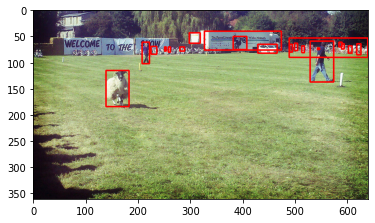

val2017/000000376900.jpg
old bbox: [[113.67, 372.4, 33.9, 46.94], [272.55, 313.18, 11.74, 22.06], [367.42, 304.18, 50.55, 79.81], [216.11, 311.09, 21.89, 37.71], [78.98, 175.88, 157.54, 424.14], [56.07, 309.31, 29.61, 55.02], [237.75, 316.41, 37.09, 66.5], [0.0, 296.8, 58.35, 87.56], [32.69, 294.54, 6.35, 6.34], [290.87, 328.73, 29.61, 53.74], [403.95, 319.74, 17.85, 28.4], [441.41, 305.9, 17.41, 42.04], [330.78, 296.37, 45.85, 85.41], [366.06, 302.08, 23.11, 34.29], [1, 270, 478, 200]]


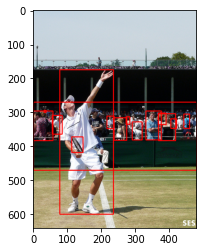

new bbox: [[113.67, 87.39999999999998, 33.9, 46.94], [272.55, 28.180000000000007, 11.74, 22.06], [367.42, 19.180000000000007, 50.55, 79.81], [216.11, 26.089999999999975, 21.89, 37.71], [78.98, -1, 157.54, 314.02], [56.07, 24.310000000000002, 29.61, 55.02], [237.75, 31.410000000000025, 37.09, 66.5], [0.0, 11.800000000000011, 58.35, 87.56], [32.69, 9.54000000000002, 6.35, 6.34], [290.87, 43.73000000000002, 29.61, 53.74], [403.95, 34.74000000000001, 17.85, 28.4], [441.41, 20.899999999999977, 17.41, 42.04], [330.78, 11.370000000000005, 45.85, 85.41], [366.06, 17.079999999999984, 23.11, 34.29], [1, -1, 478, 184]]


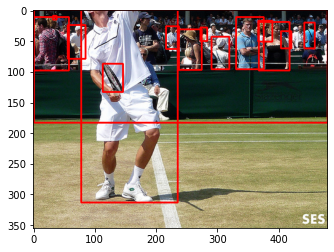

val2017/000000352491.jpg
old bbox: [[124.49, 147.98, 514.52, 277.54], [469.36, 268.58, 16.71, 11.1], [367.13, 261.11, 15.39, 10.59], [62.53, 243.45, 9.02, 21.69], [76.75, 244.78, 4.71, 14.59], [531.53, 266.6, 22.57, 17.3]]


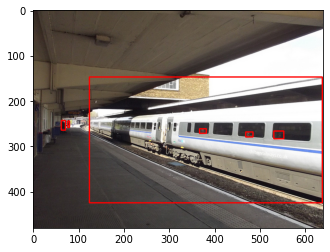

new bbox: [[124.49, 41, 514.52, 187.51999999999998], [469.36, 73.57999999999998, 16.71, 11.1], [367.13, 66.11000000000001, 15.39, 10.59], [62.53, 48.44999999999999, 9.02, 21.69], [76.75, 49.78, 4.71, 14.59], [531.53, 71.60000000000002, 22.57, 17.3]]


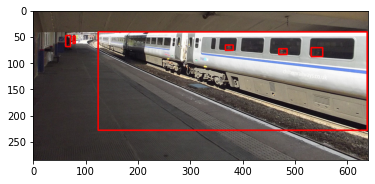

val2017/000000032735.jpg
old bbox: [[146.15, 23.02, 134.7, 131.82], [123.78, 9.66, 208.22, 202.46], [553.09, 308.57, 86.91, 15.55], [585.87, 216.12, 53.61, 106.68]]


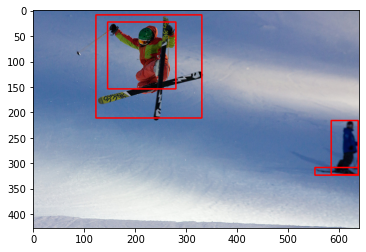

new bbox: []


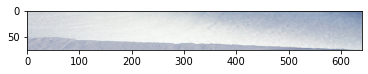

val2017/000000526751.jpg
old bbox: [[239.77, 272.34, 314.28, 128.01], [522.96, 200.04, 43.12, 10.9], [315.53, 198.18, 32.91, 14.87], [579.2, 208.68, 42.2, 9.43], [0.74, 149.72, 37.49, 55.88], [408.01, 255.63, 83.32, 28.31], [67.28, 195.0, 25.41, 7.18], [321.69, 195.84, 37.69, 13.79]]


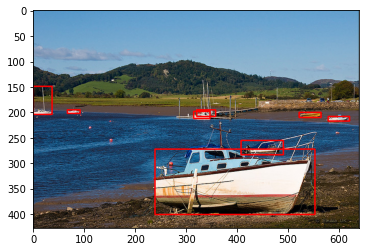

new bbox: [[239.77, 127.33999999999997, 314.28, 128.01], [522.96, 55.03999999999999, 43.12, 10.9], [315.53, 53.18000000000001, 32.91, 14.87], [579.2, 63.68000000000001, 42.2, 9.43], [0.74, 4.719999999999999, 37.49, 55.88], [408.01, 110.63, 83.32, 28.31], [67.28, 50.0, 25.41, 7.18], [321.69, 50.84, 37.69, 13.79]]


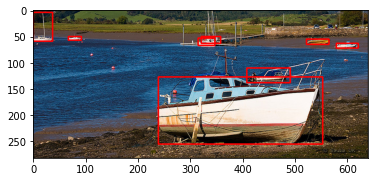

val2017/000000539962.jpg
old bbox: [[26.58, 279.93, 25.92, 25.25], [53.18, 251.74, 13.3, 26.58], [337.81, 308.86, 11.55, 11.99], [333.26, 308.63, 26.77, 15.54], [437.83, 287.23, 32.26, 34.36], [75.66, 256.32, 12.1, 36.78], [0.0, 214.23, 64.53, 24.85], [62.33, 217.26, 28.9, 25.61], [88.97, 225.84, 34.19, 49.47], [6.44, 283.43, 15.91, 27.91], [50.65, 278.46, 13.36, 25.2], [59.53, 279.52, 12.07, 24.13], [88.3, 278.64, 14.65, 17.73], [102.04, 276.86, 13.12, 20.33], [112.49, 276.18, 11.37, 17.95], [0.0, 205.2, 37.26, 31.58], [18.59, 283.3, 10.37, 27.25], [407.16, 286.45, 131.61, 100.35]]


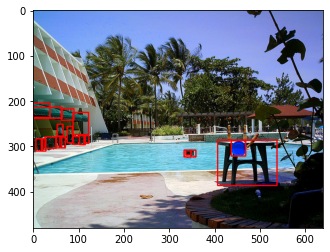

new bbox: [[26.58, 58.93000000000001, 25.92, 25.25], [53.18, 30.74000000000001, 13.3, 26.58], [337.81, 87.86000000000001, 11.55, 11.99], [333.26, 87.63, 26.77, 15.54], [437.83, 66.23000000000002, 32.26, 34.36], [75.66, 35.31999999999999, 12.1, 36.78], [0.0, -1, 64.53, 17.079999999999984], [62.33, -1, 28.9, 20.870000000000005], [88.97, 4.840000000000003, 34.19, 49.47], [6.44, 62.43000000000001, 15.91, 27.91], [50.65, 57.45999999999998, 13.36, 25.2], [59.53, 58.51999999999998, 12.07, 24.13], [88.3, 57.639999999999986, 14.65, 17.73], [102.04, 55.860000000000014, 13.12, 20.33], [112.49, 55.18000000000001, 11.37, 17.95], [0.0, -1, 37.26, 14.779999999999973], [18.59, 62.30000000000001, 10.37, 27.25], [407.16, 65.44999999999999, 131.61, 100.35]]


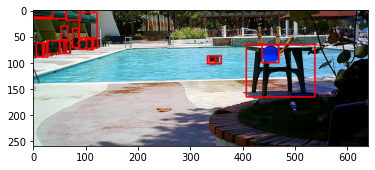

done


In [39]:
# Iterating through the images, loading the using the existing model to make a prediction
# And than showing the image

limit = 10 # I want to present only 10 images
        
for line in archive.namelist():
    if line != 'val2017/':
        picture_name = line[8:]
        #We will open the image inside the zip file, load it
        image_in_zip = archive.open(line)
        
        # We will use CV2 to decode the image
        im = cv2.imread(line)

        # Now we will use the model's predictor (pre-trained)
        panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
        
        # We'll set the segments_info containing a dict to list, to make it easier to iterate it
        seg_list = list(segments_info)
        
        # i and j will be the sizes of our image shape        
        i = im.shape[1]
        j = im.shape[0]

        # now we will iterate on our seg_list, until we will meet a sky
        # Detectron2 will label the sky inside the dictinaries inside out seg_list
        # category_id = 40 is a sky, also, we want to know if the object IS NOT a thing (isthing = False)
        # isthing says the object is NOT a background if it sets to True
        sky_destroyed = False
        labels_tensor_to_numpy = panoptic_seg.cpu().numpy()
        for indx in range(len(seg_list)):
            sky_index = None
            
            if seg_list[indx]['isthing'] == False and seg_list[indx]['category_id'] == 40:
                min_sky_row = 1000000
                max_sky_row = 0

                sky_index = indx
            # If sky_index is None, we will not initiate the loop to terminate sky
            if sky_index != None:
                sky_destroyed = True
                for j1 in range(j):
                    for i1 in range(i):
                        if(labels_tensor_to_numpy[j1][i1] == sky_index+1):
                            #We will set the colour to 255, that is white (255,255,255)
                            if j1 > max_sky_row:
                                max_sky_row = j1
                            if j1 < min_sky_row:
                                min_sky_row = j1   
                         
        if sky_destroyed == True:     
            if max_sky_row-min_sky_row < im.shape[0]-10:
                if limit >0:
                    print(line)
                    object_data = get_items_in_pic(picture_name,annotations)
                    object_bboxes = bbox_list(object_data) 
                    print('old bbox:', object_bboxes)
                    draw_bbox(coco_url+line,object_bboxes)
                    plt.show()
                    obj_edit = update_bbox_after_removing_segment(min_sky_row,max_sky_row,object_data)
                    object_bboxes_edit = bbox_list(obj_edit)     
                    print('new bbox:', object_bboxes_edit)
                    draw_bbox(coco_url+line,object_bboxes_edit,(min_sky_row,max_sky_row))
                    plt.show()
                    limit -= 1
                else:
                    object_data = get_items_in_pic(picture_name,annotations)
                    obj_edit = update_bbox_after_removing_segment(min_sky_row,max_sky_row,object_data)
                    object_bboxes_edit = bbox_list(obj_edit)     

                annotations = save_annotations(picture_name,obj_edit, annotations)

                im = np.delete(im, slice(min_sky_row, max_sky_row), axis=0)

                cv2.imwrite(f'./sky_treminated_images/{line[8:-4]}.png',im)
                
with open('data.json', 'w') as f:
    json.dump(annotations, f, ensure_ascii=False)
print('done')